# SMU BIA Datathon

## Loading libraries

In [ ]:
from collections import Counter
import ast
# from itertools import chain
import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
# import seaborn as sns
# from wordcloud import WordCloud

# Pre-processing
import re
import nltk
import demoji
from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('punkt_tab')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('vader_lexicon')

from span_marker import SpanMarkerModel
from rapidfuzz import fuzz
from rapidfuzz import process

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>


## Reading datasets

### news_excerpts_parsed

In [2]:
# Path to your Excel file
news_excerpts_parsed_path = r'/Users/ShanShan/SMU-Datathon-2025/datasets/input/news_excerpts_parsed.xlsx'

# Read the Excel file
news_excerpts_parsed_df = pd.read_excel(news_excerpts_parsed_path)

In [3]:
news_excerpts_parsed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509 entries, 0 to 1508
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Link    1509 non-null   object
 1   Text    1509 non-null   object
dtypes: object(2)
memory usage: 23.7+ KB


In [4]:
news_excerpts_parsed_df.shape

(1509, 2)

In [5]:
# Display the first few rows
news_excerpts_parsed_df.head()

,Link,Text
0,https://edition.cnn.com/2023/09/29/business/st...,Starbucks violated federal labor law when it i...
1,https://www.channelnewsasia.com/singapore/su-w...,The first suspect to plead guilty in Singapore...
2,https://edition.cnn.com/2023/05/22/tech/meta-f...,Meta has been fined a record-breaking €1.2 bil...
3,https://www.channelnewsasia.com/singapore/bill...,SINGAPORE: A 45-year-old man linked to Singapo...
4,https://edition.cnn.com/2024/03/05/politics/li...,The Department of Education imposed a record $...


### wikileaks_parsed

In [6]:
# Path to your CSV file
wikileaks_parsed_path = r'/Users/ShanShan/SMU-Datathon-2025/datasets/input/wikileaks_parsed.xlsx'

# Read the CSV file
wikileaks_parsed_df = pd.read_excel(wikileaks_parsed_path)

In [7]:
wikileaks_parsed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   PDF Path  143 non-null    object
 1   Text      143 non-null    object
dtypes: object(2)
memory usage: 2.4+ KB


In [8]:
wikileaks_parsed_df.shape

(143, 2)

In [9]:
# Display the first few rows
wikileaks_parsed_df.head()

,PDF Path,Text
0,1.pdf,Pristina Airport – Possible administrative irr...
1,1.pdf,Investigative details\n\nIn his/her interviews...
2,10.pdf,"""An interoffice memorandum providing an “outst..."
3,10.pdf,"""Allegation 2 & 3:\n\n(Specifically, three of ..."
4,10.pdf,"""When asked about this in interview, the Divis..."


## Check for missing values

### news_excerpts_parsed

In [10]:
# Check for missing values
news_excerpts_parsed_df.isnull().sum()

Link    0
Text    0
dtype: int64

### wikileaks_parsed

In [11]:
# Check for missing values
wikileaks_parsed_df.isnull().sum()

PDF Path    0
Text        0
dtype: int64

## Check for duplicated values

### news_excerpts_parsed

In [12]:
news_excerpts_parsed_df_duplicates = news_excerpts_parsed_df.duplicated().sum()

print("Number of duplicates in dataset:", news_excerpts_parsed_df_duplicates)

Number of duplicates in dataset: 0


### wikileaks_parsed

In [13]:
wikileaks_parsed_df_duplicates = wikileaks_parsed_df.duplicated().sum()

print("Number of duplicates in dataset:", wikileaks_parsed_df_duplicates)

Number of duplicates in dataset: 0


## Describing dataset

### news_excerpts_parsed

In [14]:
news_excerpts_parsed_df.describe()

,Link,Text
count,1509,1509
unique,1508,1509
top,https://cnalifestyle.channelnewsasia.com/dinin...,Starbucks violated federal labor law when it i...
freq,2,1


### wikileaks_parsed

In [15]:
wikileaks_parsed_df.describe()

,PDF Path,Text
count,143,143
unique,44,143
top,2.pdf,Pristina Airport – Possible administrative irr...
freq,17,1


## Pre-processing text

preprocess_text:

1. Converting to Lowercasing
2. Removing Emojis
3. Normalize Contractions
4. Removing Punctuations
5. Removal of Links
6. Removing Special Characters
7. Removing Mentions
8. Removing Line breakers
9. Removal of UTF-encoding
10. Removing Hashtags
11. Removing Special Characters
12. Removing Extra Whitespaces

lemmatize_and_remove_stopwords:
1. Removing Stopwords
2. Tokenization
3. Lemmatization

In [16]:
def remove_emojis(text):
    """Remove emojis from the text."""
    return demoji.replace(text, '')

def clean_hashtags(review):
    """Remove hashtags from the text."""
    # Remove hashtags at the end of the sentence
    new_review = " ".join(word.strip() for word in re.split(r'#(?!(?:hashtag)\b)[\w\'-]+(?=(?:\s+#[\w\'-]+)*\s*$)', review))
    # Remove '#' symbol from words in the middle of the sentence
    new_review2 = " ".join(word.strip() for word in re.split(r'#|_', new_review))
    return new_review2

def filter_chars(a):
    """Filter out unwanted characters from the text."""
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text):
    """Remove multiple spaces in the text."""
    return re.sub(r"\s\s+", " ", text)

def normalize_contractions(text):
    """Normalize common English contractions."""
    contractions = {
        "can't": "cannot",
        "won't": "will not",
        "don't": "do not",
        "doesn't": "does not",
        "didn't": "did not",
        "haven't": "have not",
        "hasn't": "has not",
        "isn't": "is not",
        "aren't": "are not",
        "we're": "we are",
        "they're": "they are",
        "i'm": "I am",
        "you're": "you are",
        "it's": "it is",
        "he's": "he is",
        "she's": "she is",
        "i've": "I have",
        "you've": "you have",
        "they've": "they have",
        "that's": "that is",
        "what's": "what is",
        "where's": "where is",
        "who's": "who is",
        "let's": "let us",
        "o'clock": "of the clock",
        "wouldn't": "would not",
        "shouldn't": "should not",
        "couldn't": "could not",
        "would've": "would have",  
        "i'd": "I would",           
        "i'll": "I will",           
        "there's": "there is"       
    }
    # Replace contractions in the text
    for contraction, full in contractions.items():
        text = text.replace(contraction, full)
    return text

def normalize_punctuation(text):
    """Replace multiple consecutive periods and punctuation marks with a single instance and ensure spaces."""
    text = re.sub(r'\.{2,}', '.', text)  # Normalize ellipses
    text = re.sub(r'([!?.])\1+', r'\1', text)  # Normalize multiple punctuation marks
    # Add space after punctuation if not at the end of the string
    text = re.sub(r'([!?.])(?=\S)', r'\1 ', text)  
    return text

def preprocess_text(text: str, remove_stopwords: bool = True) -> str:
    """Preprocess the input text."""

# Check if the input is an integer, float, or contains only numeric characters
    if isinstance(text, (int, float)) or (isinstance(text, str) and text.replace('.', '', 1).isdigit()):
        return ""  # Return an empty string or any placeholder you'd like

    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove emojis 
    text = remove_emojis(text)
    # Normalize contractions
    text = normalize_contractions(text)
    # Normalize punctuation
    text = normalize_punctuation(text)
    text = re.sub(r'([!.,?;:])', r' \1 ', text)  # Add spaces around punctuation before removal
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize extra spaces
    # Remove double quotes
    text = re.sub(r'"', '', text)
    # Normalize dashes
    text = re.sub(r'-{2,}', '-', text)  # Replace multiple dashes with a single dash
    text = re.sub(r'\s*-\s*', ' ', text)  # Remove isolated dashes
    # Remove links
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    # Remove specific special characters
    text = re.sub(r'[\\/×\^\]:,.\[÷]', '', text) 
    # Remove all spaces and line breaks
    text = text.replace('\r', '').replace('\n', '')
    # Remove UTF encodings
    text = re.sub(r'[^\x00-\x7f]', r'', text) 
    # Clean hashtags
    text = clean_hashtags(text)
    # Filter special characters
    text = filter_chars(text)
    # Remove multiple spaces
    text = remove_mult_spaces(text)
    
    return text

def lemmatize_and_remove_stopwords(text, remove_stopwords: bool = True):
    """Lemmatize the text and remove stopwords."""
    special_characters = r'[@_!#$%^&*()<>?/\|}{~:]'
    STOPWORDS = set(stopwords.words('english'))
    lemmatizer = nltk.WordNetLemmatizer()

    if remove_stopwords:
        tokens = nltk.word_tokenize(text)
        tokens = [w for w in tokens if (not all(c in special_characters for c in w)) and (not w.isdigit())]
        tokens = [lemmatizer.lemmatize(w) for w in tokens]
        tokens = [w.lower().strip() for w in tokens if w.lower() not in STOPWORDS]
        return ' '.join(tokens)
    return text

In [17]:
# Apply the preprocessing function to the 'text_' column in fake_reviews_df
news_excerpts_parsed_df['cleaned_text'] = news_excerpts_parsed_df['Text'].apply(preprocess_text)

news_excerpts_parsed_df['final_cleaned_review'] = news_excerpts_parsed_df['cleaned_text'].apply(lemmatize_and_remove_stopwords)

In [18]:
# Apply the preprocessing function to the 'text_' column in fake_reviews_df
wikileaks_parsed_df['cleaned_text'] = wikileaks_parsed_df['Text'].apply(preprocess_text)

wikileaks_parsed_df['final_cleaned_teview'] = wikileaks_parsed_df['cleaned_text'].apply(lemmatize_and_remove_stopwords)

## NER

### Extracting entities

In [ ]:
model = SpanMarkerModel.from_pretrained("tomaarsen/span-marker-mbert-base-multinerd")

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [20]:
def extract_entities(text):
    entities = model.predict(text)  # Extract entities from the text
    return entities

In [21]:
# Apply to datasets
news_excerpts_parsed_df["entities"] = news_excerpts_parsed_df["Text"].apply(extract_entities)

wikileaks_parsed_df["entities"] = wikileaks_parsed_df["Text"].apply(extract_entities)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [22]:
news_excerpts_parsed_cleaned_output_path = '/Users/ShanShan/SMU-Datathon-2025/datasets/output/processed_news_excerpts_parsed.csv'

# Save to CSV in the specified output directory
news_excerpts_parsed_df.to_csv(news_excerpts_parsed_cleaned_output_path, index=False)

In [23]:
wikileaks_parsed_cleaned_output_path = '/Users/ShanShan/SMU-Datathon-2025/datasets/output/processed_wikileaks_parsed.csv'

# Save to CSV in the specified output directory
wikileaks_parsed_df.to_csv(wikileaks_parsed_cleaned_output_path, index=False)

### Reading files

In [199]:
# Path to your Excel file
news_excerpts_parsed_cleaned_output_path = '/Users/ShanShan/SMU-Datathon-2025/datasets/output/processed_news_excerpts_parsed.csv'

# Read the Excel file
news_excerpts_parsed_df = pd.read_csv(news_excerpts_parsed_cleaned_output_path)

In [200]:
# Path to your CSV file
wikileaks_parsed_cleaned_output_path = '/Users/ShanShan/SMU-Datathon-2025/datasets/output/processed_wikileaks_parsed.csv'

# Read the CSV file
wikileaks_parsed_df = pd.read_csv(wikileaks_parsed_cleaned_output_path)

### Formatting entities

In [201]:
# Convert the string representation of lists/dictionaries to actual Python objects
news_excerpts_parsed_df['entities'] = news_excerpts_parsed_df['entities'].apply(ast.literal_eval)

wikileaks_parsed_df['entities'] = wikileaks_parsed_df['entities'].apply(ast.literal_eval)

In [202]:
# Function to extract (span, label) pairs
def extract_span_label_pairs(entities):
    return [(entity['span'], entity['label']) for entity in entities]

In [203]:
# Apply the function to extract (span, label) pairs from 'entities' column for both datasets
news_excerpts_parsed_df['span_label_pairs'] = news_excerpts_parsed_df['entities'].apply(extract_span_label_pairs)

wikileaks_parsed_df['span_label_pairs'] = wikileaks_parsed_df['entities'].apply(extract_span_label_pairs)

In [204]:
# Combine the span-label pairs from both dataframes
all_span_label_pairs = (
    news_excerpts_parsed_df['span_label_pairs'].sum() +  # Sum of span-label pairs from news dataset
    wikileaks_parsed_df['span_label_pairs'].sum()        # Sum of span-label pairs from wikileaks dataset
)

### Fuzzy matching 

In [205]:
# # Function to perform fuzzy matching between entities using rapidfuzz
# def fuzzy_match_entities_rapidfuzz(entities, threshold=95):
#     matched_pairs = []

#     # Loop through entities and check for fuzzy matches
#     for i, (entity1, label1) in enumerate(entities):
#         for j, (entity2, label2) in enumerate(entities):
#             if i < j:  # To avoid self-comparison and double counting
#                 similarity = fuzz.ratio(entity1, entity2)  # Compute similarity score
#                 if similarity >= threshold:
#                     matched_pairs.append(((entity1, label1), (entity2, label2), similarity))
    
#     return matched_pairs

In [206]:
# # Converting to a set to remove duplicates
# unique_entities = set(all_span_label_pairs)

In [207]:
# # Get fuzzy matches using rapidfuzz
# matched_entities_rapidfuzz = fuzzy_match_entities_rapidfuzz(unique_entities)

In [208]:
# # Convert matched pairs to DataFrame
# matched_entities_rapidfuzz_df = pd.DataFrame(matched_entities_rapidfuzz, columns=["Entity 1", "Entity 2", "Similarity"])

### Counting entities

In [209]:
# Count the frequency of each span-label pairing
span_label_pair_counts = Counter(all_span_label_pairs)

# Convert the counts into a DataFrame with entity, label, and count columns
combined_entity_df = pd.DataFrame(span_label_pair_counts.items(), columns=["entity_label", "count"])

# Split the 'entity_label' column into 'entity' and 'label'
combined_entity_df[['entity', 'label']] = pd.DataFrame(combined_entity_df['entity_label'].to_list(), index=combined_entity_df.index)

# Drop the original 'entity_label' column
combined_entity_df = combined_entity_df.drop(columns=['entity_label'])

## Entity

### Distribution of entities 

In [210]:
# Assuming combined_entity_df has columns: 'entity', 'label', and 'count'
top_10_entities = combined_entity_df.groupby('entity')['count'].sum().sort_values(ascending=False).head(10)


In [211]:
top_10_entities

entity
Singapore           393
China               313
Russia              123
United States       103
Japan                91
India                80
Ukraine              77
Reuters              72
Israel               71
Pristina Airport     68
Name: count, dtype: int64

### Distribution of unique entities per label

In [224]:
unique_entities_per_label = combined_entity_df.groupby('label')['entity'].nunique()

In [225]:
unique_entities_per_label

label
ANIM       16
CEL         6
DIS        54
EVE        71
FOOD       85
INST       44
LOC      1327
MEDIA     185
MYTH        7
ORG      2149
PER      2015
PLANT      13
TIME       37
VEHI       15
Name: entity, dtype: int64

## Label

### Distribution of labels

In [212]:
entity_label_counts = combined_entity_df['label'].value_counts()

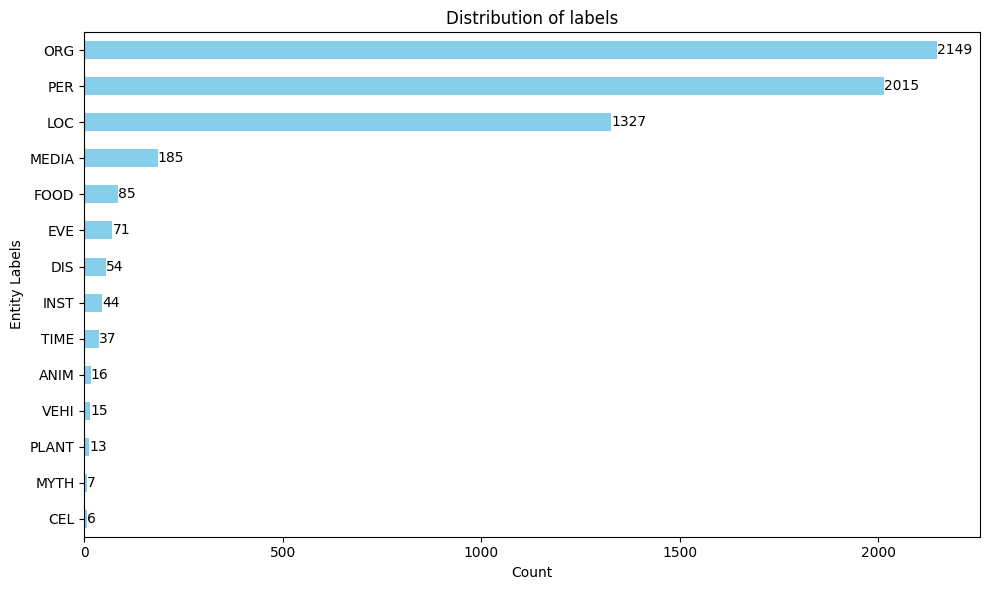

In [213]:
# Sort the values from most to least
entity_label_counts_bar = entity_label_counts.sort_values(ascending=True)

# Plotting the horizontal bar chart
plt.figure(figsize=(10, 6))
ax = entity_label_counts_bar.plot(kind='barh', color='skyblue')

# Adding titles and labels
plt.title('Distribution of labels')
plt.xlabel('Count')
plt.ylabel('Entity Labels')

# Adding counts on top of each bar
for index, value in enumerate(entity_label_counts_bar):
    ax.text(value + 0.2, index, str(value), va='center', ha='left')

# Display the chart
plt.tight_layout()  # Adjust layout to ensure labels fit well
plt.show()


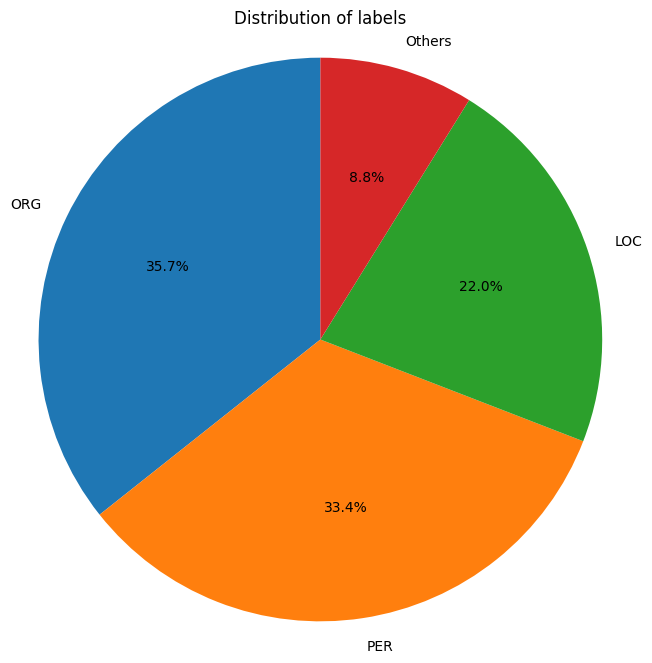

In [214]:
# Get the top 4 labels and sum the rest as 'Others'
top_3_labels = entity_label_counts.head(3)
others_count = entity_label_counts[3:].sum()

# Combine top 4 labels with the 'Others' category
entity_label_counts_pie = pd.concat([top_3_labels, pd.Series({'Others': others_count})])

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(entity_label_counts_pie, labels=entity_label_counts_pie.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of labels')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.show()


In [215]:
# Calculate the top 3 labels based on their counts
top_3_labels = entity_label_counts.head(3).index

# Create a new 'new_label' column, grouping other labels as 'OTHERS'
combined_entity_df['new_label'] = combined_entity_df['label'].apply(
    lambda x: x if x in top_3_labels else 'OTHERS'
)